# Covariance matrix

In [ ]:
import pandas as pd 
import numpy as np
import os 
import sys
from glob import glob
import pickle

import librosa
from scipy.io import wavfile
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# sys.path.append(os.path.join(os.getcwd(), '..', 'utils'))

from restore import restore, restore_matrix
sns.set_theme()

%load_ext autoreload
%autoreload 2

path = os.getcwd()
path = os.path.join(path, 'data', 'pack1')

files = [f for f in glob(os.path.join(path, '*.csv'))]
files

In [15]:
dfs = [pd.read_csv(file, delimiter=';') for file in files]
test_sizes = [np.ceil(df.shape[0] * 0.15).astype(int) for df in dfs]
train_dfs = [df.iloc[:-test_size, :] for df, test_size in zip(dfs, test_sizes)]
test_dfs = [df.iloc[-test_size:, :] for df, test_size in zip(dfs, test_sizes)]

In [20]:
train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)

train_df.shape, test_df.shape

((6480697, 11), (1143658, 11))

In [22]:
X_train = train_df.iloc[:, 2:].to_numpy().T
labels_train = train_df.label.values

X_test = test_df.iloc[:, 2:].to_numpy().T
labels_test = test_df.label.values

print('Train data', X_train.shape, labels_train.shape)
print('Test data', X_test.shape, labels_test.shape)

Train data (9, 6480697) (6480697,)
Test data (9, 1143658) (1143658,)


In [45]:
def compute_covariance(X):
    """
    Computes covariance vector

    X : np.array of shape (n_channels, n_samples)

    returns:
    c : covariance vector
    """
    n_channels = X.shape[0]
    return np.cov(X)[np.triu_indices(n_channels, k=1)]

def get_listen_inds(labels):
    return np.where(labels > 10)[0]

def get_repeat_inds(labels):
    return np.where((labels < 10) * (labels > 0))[0]

def get_listen_repeat_inds(labels):
    non_zero = labels[labels > 0]
    non_zero_inds = np.where(labels > 0)[0]

    left, right = 0, 1
    while True:
        if right >= non_zero.shape[0]:
            break
        if non_zero[left] == non_zero[right] + 10:
            left += 2
            right += 2
            continue
        non_zero[left] = 0
        left += 1
        right += 1
    return non_zero_inds[non_zero > 0]

def add_zero_inds(inds): # only for paired inds
    rpt = inds[1::2]
    noise = rpt + 1000 # 1000ms shift
    union = np.sort(np.concatenate((inds, noise), axis=0))
    return union

def prolong_inds(inds, frame_size):
    add = np.arange(frame_size)
    frames = [add + ind for ind in inds]
    return np.concatenate(frames, axis=0)

def window_inds(inds, frame_size, window_size, hop_length):
    inds = inds.reshape(-1, frame_size)
    n_windows = (frame_size - window_size) / hop_length + 1
    n_windows = int(np.floor(n_windows))

    res = np.zeros((inds.shape[0], n_windows, window_size))
    for i in range(n_windows):
        start = i * hop_length
        res[:, i, :] = inds[:, start:(start + window_size)]

    return res.astype(int) # shape (batch, n_windows, window_size) 

def split_signals(X, inds):
    """
    X: np array of shape (n_channels, n_samples)
    inds: np array of shape (batch, n_windows, window_size) 

    returns:
    S: np array of shape (n_channels, batch * n_windows, window_size)
    """

    S = X[:, inds.ravel()]
    shape = inds.shape
    return S.reshape(X.shape[0], shape[0] * shape[1], shape[2])

def get_cov(S):
    """
    S: np array of shape (n_channels, batch * n_windows, window_size)

    returns: 
    C: np array of shape (batch * n_windows, n_channels*(n_channels - 1)/2)
    """
    n_channels = S.shape[0]
    C = np.zeros((S.shape[1], int(n_channels * (n_channels - 1) / 2)))
    for win in range(S.shape[1]):
        X = S[:, win, :] # shape (n_channels, n_samples)
        C[win] = compute_covariance(X)

    return C

# def convert(X, labels, frame=278, window=50, hop=12, extra=None):
def convert(X, labels, frame=278, window=50, hop=2, val_split=False, extra=None):
    storage = os.path.join(path, 'converted')

    inds = get_listen_repeat_inds(labels)
    inds = add_zero_inds(inds)

    #############
    # listen noise
    mask = np.tile(np.array([True, False, True]), inds.shape[0] // 3)
    inds = inds[mask]

    storage = os.path.join(storage, 'listen-noise')
    if not os.path.isdir(storage):
        os.mkdir(storage)

    y = (labels[inds] > 0).astype(int)
    #############

    inds = prolong_inds(inds, frame)
    
    inds = window_inds(inds, frame, window, hop)
    S = split_signals(X, inds)
    S = get_cov(S)

    if val_split:
        n_windows = (frame - window) / hop + 1
        n_windows = int(np.floor(n_windows))

        window = S.shape[1]
        S_train, S_val, y_train, y_val = train_test_split(S.reshape(-1, n_windows, window), y, test_size=0.15)

        np.savetxt(os.path.join(storage, 'A_train.csv'), S_train.reshape(-1, window), delimiter=',')
        np.savetxt(os.path.join(storage, 'y_train.csv'), y_train, delimiter=',')
        np.savetxt(os.path.join(storage, 'A_val.csv'), S_val.reshape(-1, window), delimiter=',')
        np.savetxt(os.path.join(storage, 'y_val.csv'), y_val, delimiter=',')
    elif extra is None:
        np.savetxt(os.path.join(storage, 'A.csv'), S, delimiter=',')
        np.savetxt(os.path.join(storage, 'y.csv'), y, delimiter=',')
    else:
        np.savetxt(os.path.join(storage, f'A_{extra}.csv'), S, delimiter=',')
        np.savetxt(os.path.join(storage, f'y_{extra}.csv'), y, delimiter=',')

    return S, y

In [46]:
S, y = convert(X_train, labels_train, val_split=True)
print(S.shape, y.shape)
convert(X_test, labels_test, extra='test');

(2886, 115, 36) (2886,)


In [39]:
331890 / 115

2886.0

### Covariance Matrix Parameters:

    1.  window (row): 50ms (50 samples) -- 1102 sound samples
    2.  HOP_LENGTH: 32ms (32 samples)
    3.  frame size: 306 samples
    4.  9 windows

### STFT Parameters:


#### 6 fft windows in a row

    1.  FRAME_SIZE = 512
    2.  SR = 22050
    3.  HOP_LENGTH = 118
    4.  Each row: 1102 samples = 6 windows. Entire phoneme = 9 rows (6766 samples)


#### 1 fft window in a row

    1.  FRAME_SIZE = 1102 (50 ms)
    2.  SR = 22050
    3.  HOP_LENGTH = 275
    4.  20 frames = 6327 samples = 0.287 sec


In [33]:
# sound samples
(20 - 1) * 275 + 1102

6327

# Spectrums

In [26]:
phonemes = ['A', 'B', 'f', 'G', 'm', 'R', 'u']
files = [p + '.wav' for p in phonemes]

path_snd = '/home/srg/Documents/MSU/EEG/data/sound_files/'
files = [os.path.join(path_snd, p) for p in files]

files

['/home/srg/Documents/MSU/EEG/data/sound_files/A.wav',
 '/home/srg/Documents/MSU/EEG/data/sound_files/B.wav',
 '/home/srg/Documents/MSU/EEG/data/sound_files/f.wav',
 '/home/srg/Documents/MSU/EEG/data/sound_files/G.wav',
 '/home/srg/Documents/MSU/EEG/data/sound_files/m.wav',
 '/home/srg/Documents/MSU/EEG/data/sound_files/R.wav',
 '/home/srg/Documents/MSU/EEG/data/sound_files/u.wav']

In [9]:
sounds = [librosa.load(p, sr=22050)[0] for p in files]
type(sounds[0])

numpy.ndarray

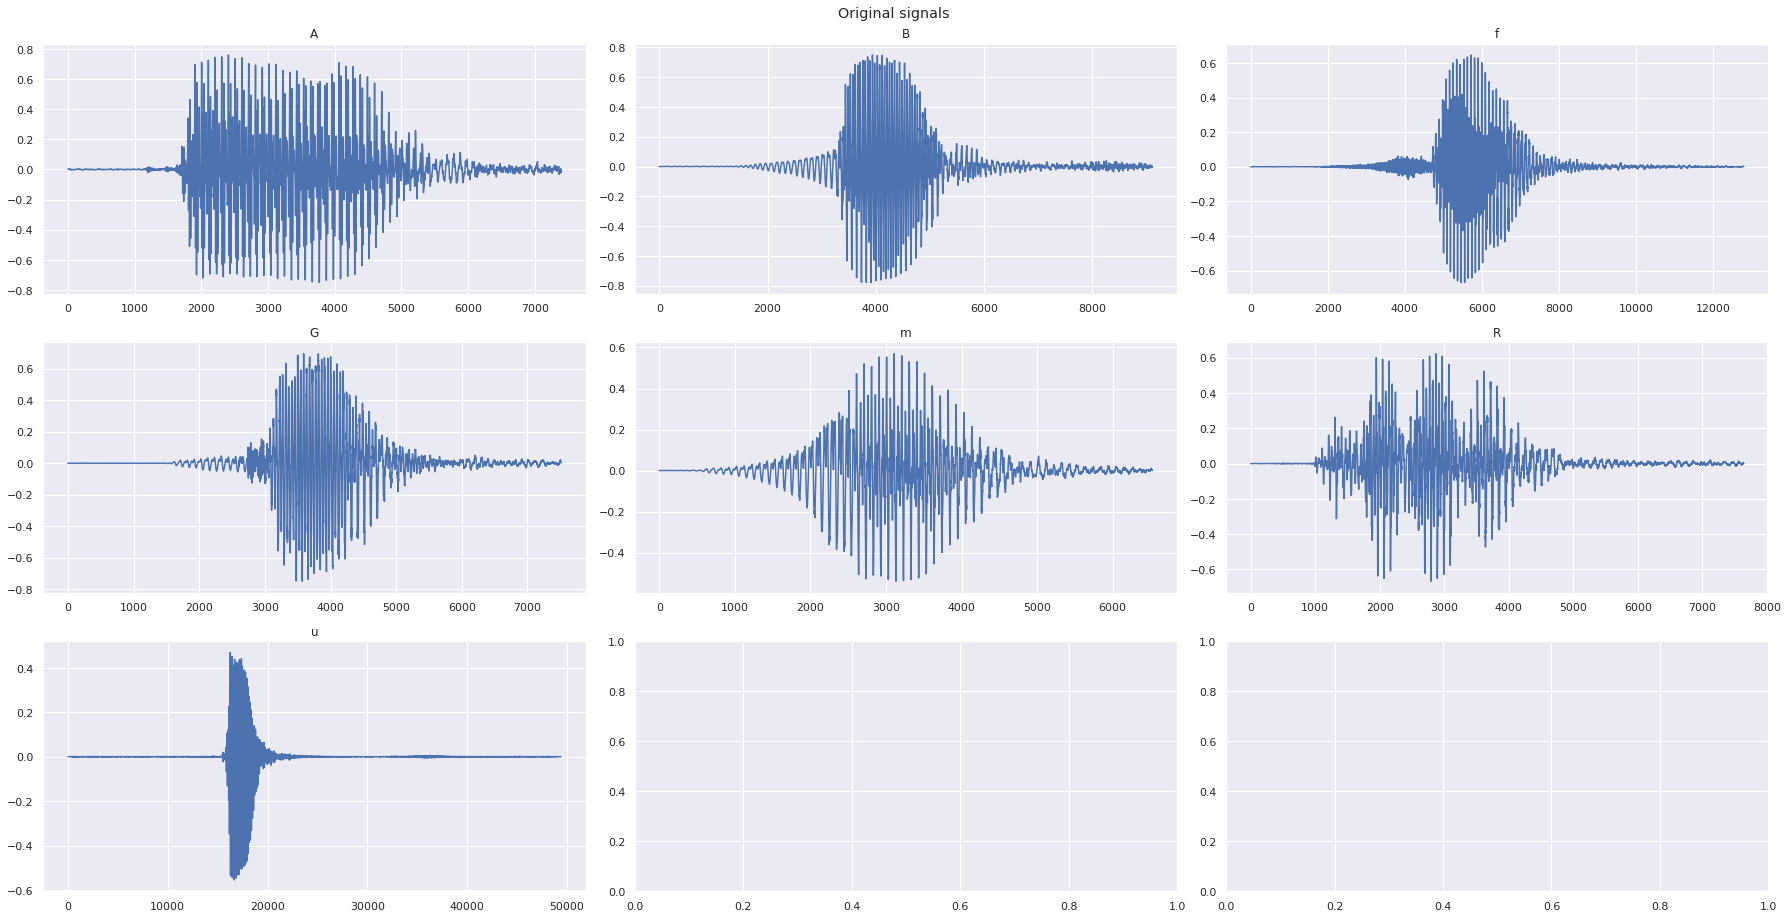

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 13))
for i in range(7):
    axes[i // 3][i % 3].plot(sounds[i])
    axes[i // 3][i % 3].set_title(phonemes[i])

fig.suptitle('Original signals')
plt.tight_layout()

In [11]:
n_samples = 6327

slices = [
    slice(-n_samples, None),     # A
    slice(1500, 1500+n_samples), # B
    slice(2100, 2100+n_samples), # f
    slice(-n_samples, None),     # G
    slice(None, n_samples),           # m
    slice(500, 500+n_samples),   # R 
    slice(15000, 15000+n_samples)# u
]
cut = [snd[slc] for snd, slc in zip(sounds, slices)]
# cut[4] = np.concatenate((cut[4], np.zeros(n_samples - 6526))) # too small

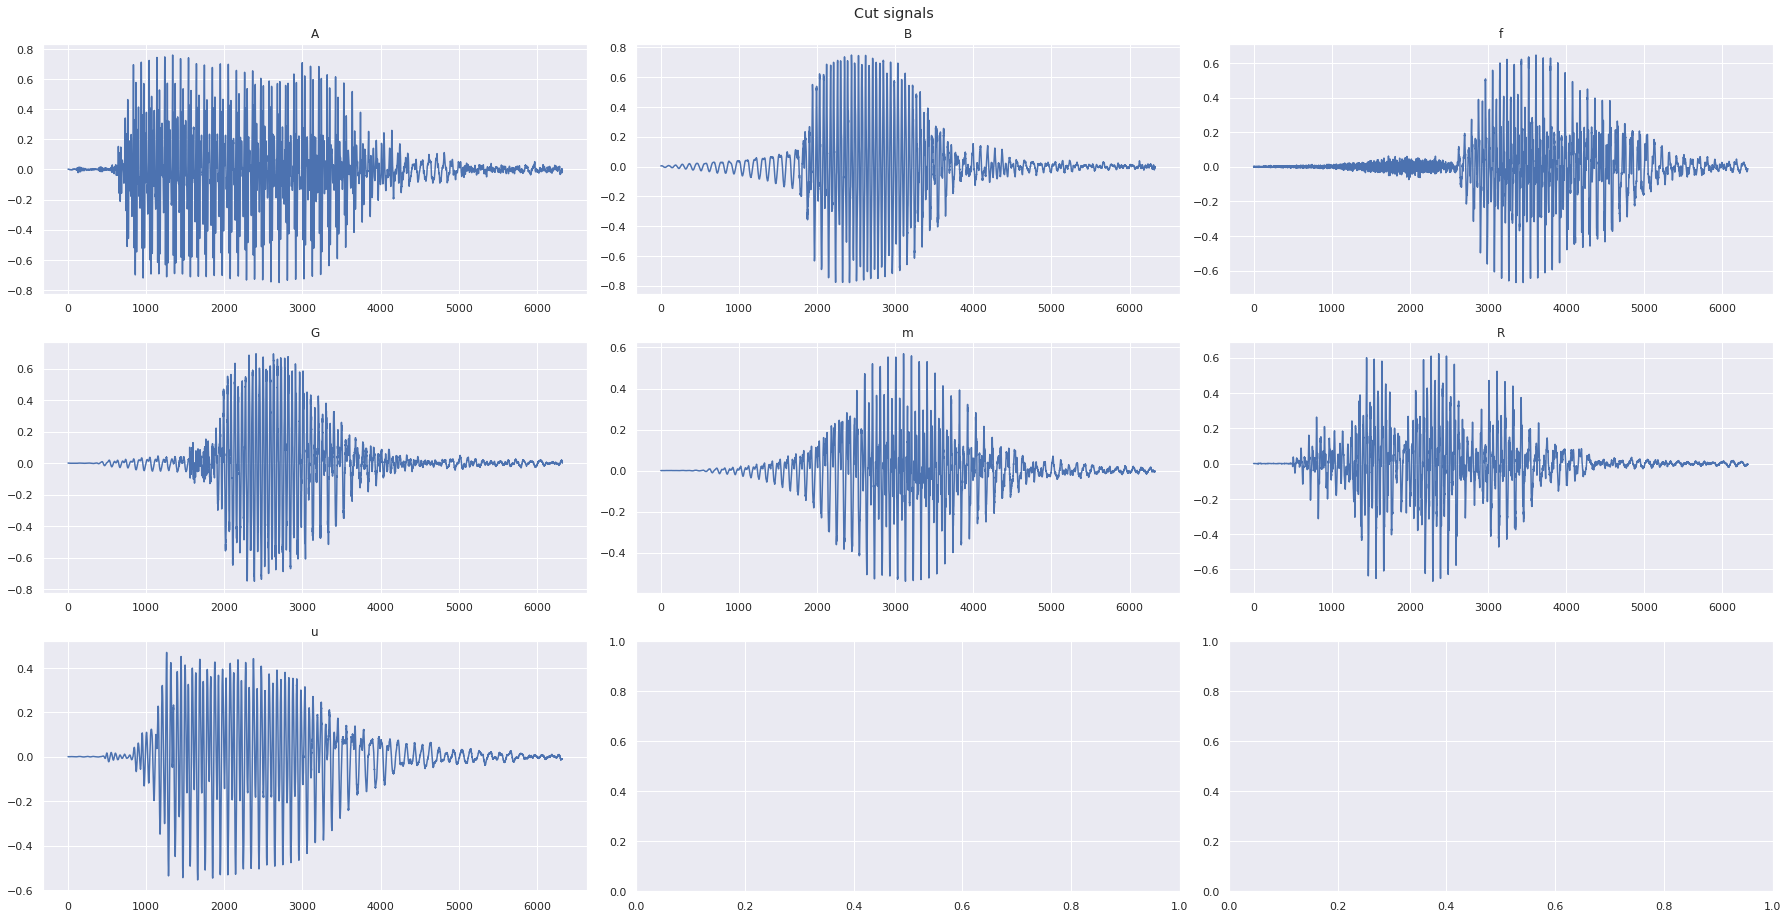

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 13))
for i in range(7):
    axes[i // 3][i % 3].plot(cut[i])
    axes[i // 3][i % 3].set_title(phonemes[i])

fig.suptitle('Cut signals')
plt.tight_layout()

In [11]:
# to spectrums
# 257 freq bins
# 54 frames

FRAME_SIZE = 1102
HOP_LENGTH = 275

In [20]:
specs = [np.abs(librosa.stft(s, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False))
         for s in cut]
specs = [np.zeros_like(specs[0])] + specs
specs[0].shape

(552, 20)

In [21]:
# specs = [s.T.reshape(9, -1) for s in specs]
specs = [s.T for s in specs]
specs = np.stack(specs)
specs.shape

(8, 20, 552)

In [22]:
# test = specs.reshape(8, 54, 257).reshape(-1, 257).T
res = restore(specs.reshape(160, 552).T, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
res.shape

(44827,)

In [28]:
wavfile.write(os.path.join(path, 'restored.wav'), 22050, res)

In [31]:
# saving spectrums

with open(os.path.join(path, 'spectrums.pickle'), 'wb') as handle:
    pickle.dump(specs, handle)

# X Operator

AX = B

In [16]:
A = np.loadtxt(os.path.join(path, 'converted', 'listen-noise', 'A.csv'), delimiter=',', ndmin=2)
y = np.loadtxt(os.path.join(path, 'converted', 'listen-noise', 'y.csv'), delimiter=',', ndmin=2).ravel()
with open(os.path.join(path, 'spectrums.pickle'), 'rb') as handle:
    specs = pickle.load(handle)
specs.shape

(8, 20, 552)

In [17]:
A = A.reshape(242, 20, 36)
# A = A[y[y > 0].astype(int)]
A = A.reshape(-1, 36)
A.shape

(4840, 36)

In [18]:
y[y > 10] = y[y > 10] - 10
# y = y[y > 0]
B = specs[y.astype(int)]
B.shape

(242, 20, 552)

In [19]:
B = B.reshape(-1, 552)
A.shape, B.shape

((4840, 36), (4840, 552))

In [20]:
At = A #/ np.max(np.abs(A))
Bt = B #/ np.max(np.abs(B))
# At = np.random.rand(1000, 36)
# Bt = np.random.rand(1000, 1542)

A_inv = np.linalg.pinv(At)
X = A_inv @ Bt

np.linalg.norm(At @ X - Bt)

3965.449153415182

In [21]:
res = At @ X
res = restore_matrix(res, FRAME_SIZE, HOP_LENGTH)
wavfile.write(os.path.join(path, 'restored.wav'), 22050, res)